# Introduction

This notebook looks at the auditory data in the DOD dataset, producing numerous PCA visualizations left for interpretation.

First, make sure these libraries are installed. Uncomment to install them.

In [23]:
# Required libraries
# !pip install mpl_axes_aligner openpyxl
# !pip install numpy pandas scikit-learn seaborn missingno

In [24]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import mpl_axes_aligner
from sklearn.cluster import KMeans
import itertools
import math
import seaborn as sns

Set these paths to the correct files in your working directory

In [25]:
label_path = '../data/DOD_clinical_labels_from_excel.xlsx'
logs_path = '../data/Data Processing Logs.xlsx'
data_path = '../data/DOD_clinical_data.xlsx'

# Loading & Cleaning Data

- Our data is in an excel file with multiple sheets. 
- Our end goal is to combine everything into 1 dataframe. 
- The following cell creates a separate dataframe for each sheet in our excel file.

In [26]:
# Loading the data
import pandas as pd
import numpy as np

def load_data(path): # = 'DOD_clinical_data.xlsx'
	"""
	Params:
	- path: an excel file that has multiple sheets.
	Outputs:
	- data: a dictionary of dataframes, each dataframe corresponding to a sheet on the excel.
	"""
	xlsx = pd.ExcelFile(path)
	data = {}
	for sheetname in xlsx.sheet_names:
		sheet = pd.read_excel(xlsx, sheet_name=sheetname)
		data[sheetname] = sheet
	return data

# Getting each sheet from the excel file. Setting the ID avoids duplicated data points
data = load_data(data_path)
aircon_low_df = data['AirCon'].set_index(data['AirCon']['ID'])
aircon_high_df = data['AirConHigh'].set_index(data['AirConHigh']['ID'])
bonecon_df= data['BoneCon'].set_index(data['BoneCon']['ID'])
aircon_low_df = data['AirCon'].set_index(data['AirCon']['ID'])
speech_df = data['Speech'].set_index(data['Speech']['ID'])
tymp_df = data['Tymp'].set_index(data['Tymp']['ID'])
summary_df = data['Summary'].set_index(data['Summary']['ID'])

- Because some columns are redundant across the sheets and some are simply uninformative for PCA (i.e. shows the date they took the experiment), we'll need to drop some columns in the sheets. 
- While we're at it, let's also verage between "left" and "right" values (i.e. left ear PTA vs. right ear PTA)

In [27]:
# Grab the average between a left and right column. Unlike .mean(), this handles NA values.
def average_columns(left_column, right_column):
	"""
  Params:
  - left_column & right_column: two columns that need to be averaged in a dataframe (assumes that each row is a participant)
	Example usage:
	- test_df['PTA_A'] = average_columns(test_df['PTA_A_L'], test_df['PTA_A_R'])
	"""
	averages = []
	for left, right in zip(left_column.values, right_column.values):
		average = 0
		if left == None and right == None:
			average = None
		elif left == None:
			average = right
		elif right == None:
			average = left
		else:
			average = (float(left) + float(right))/2
		averages.append(average)
	return averages

# Organize AirCon Data
aircon_high_df.drop(columns=['RU8000', 'LU8000'], inplace=True) # Redundant info
aircon_all_df = pd.concat([aircon_low_df, aircon_high_df], axis = 1)
aircon_all_df_cleaned = aircon_all_df.replace({"DNC" : None, "NR" : None})
aircon_all_df_averaged = aircon_all_df_cleaned.copy() # Average between left and right
for column in aircon_all_df_averaged:
	if 'RU' in column:
		right, frequency = column.split('U')
		aircon_all_df_averaged["A_"+frequency] = average_columns(aircon_all_df_averaged[column], aircon_all_df_averaged['LU'+str(frequency)])
aircon_all_df_averaged['PTA_A'] = average_columns(aircon_all_df_averaged['PTA_A_R'], aircon_all_df_averaged['PTA_A_L'])
aircon_all_df_final = aircon_all_df_averaged.drop(columns=[*aircon_all_df_cleaned.columns]) # Drop the original columns, leaving just the averages
print(f"Final AirCon data length: {len(aircon_all_df_final)}")

# Organize BoneCon data
bonecon_df_cleaned = bonecon_df.replace({"DNC" : None, "NR" : None})
keep = 'PTA_B_R	PTA_B_L	RU250	RU500	RU1000	RU2000	RU3000	RU4000	RU6000	RU8000	LU250	LU500	LU1000	LU2000	LU3000	LU4000	LU6000	LU8000'.split('\t')
bonecon_df_cleaned = bonecon_df_cleaned[keep] # Keep only unmasked data since mask doesn't have a lot of data.
bonecon_df_averaged = bonecon_df_cleaned.copy() # Average between left and right
for column in bonecon_df_averaged:
	if 'RU' in column:
		right, frequency = column.split('U')
		bonecon_df_averaged["B_"+frequency] = average_columns(bonecon_df_averaged[column], bonecon_df_averaged['LU'+str(frequency)])
bonecon_df_averaged['PTA_B'] = average_columns(bonecon_df_averaged['PTA_B_R'], bonecon_df_averaged['PTA_B_L'])
bonecon_df_final = bonecon_df_averaged.drop(columns=[*bonecon_df_cleaned.columns]) # Drop the original columns, leaving just the averages
print(f"Final BoneCon data length: {len(bonecon_df_final)}")

# Organize Speech data
speech_df_cleaned = speech_df.drop(columns=['ID', 'Speech_Date', 'R_LIST', 'L_LIST', 'QuickSIN List 1', 'QuickSIN List 2', 'Notes'])
speech_df_averaged = speech_df_cleaned.copy() # Average between left and right. Note: R_WRS_MASK might have a space in the column name.
keep = ["QuickSIN_Average_SNR_Loss"]
for column in speech_df_averaged:
	if 'R_' in column and column not in keep:
		_, name = column.split('R_')
		speech_df_averaged[name] = average_columns(speech_df_averaged[column], speech_df_averaged['L_'+str(name)])
speech_df_final = speech_df_averaged.drop(columns=list(set([*speech_df_cleaned.columns]) - set(keep))) # Drop the original columns, leaving just the averages
print(f"Final Speech data length: {len(speech_df_final)}")

# Organize Tymp data
tymp_df_cleaned = tymp_df.drop(columns=['ID', 'Tymp_Date'])
tymp_df_averaged = tymp_df_cleaned.copy() # Average between left and right
for column in tymp_df_averaged:
	if 'TR_' in column and column not in keep:
		_, name = column.split('TR_')
		tymp_df_averaged[name] = average_columns(tymp_df_averaged[column], tymp_df_averaged['TL_'+str(name)])
tymp_df_final = tymp_df_averaged.drop(columns=list(set([*tymp_df_cleaned.columns]) - set(keep))) # Drop the original columns, leaving just the averages
print(f"Final Tymp data length: {len(tymp_df_final)}")

# Organize Summary data
summary_df_columns = ['PTA_pt5to2', 'PTA_3to6', 'PTA_12pt5to16',
		   'PTA_Low', 'PTA_Med', 'PTA_High',
		   'DPavg_Low', 'DPavg_Med', 'DPavg_High']
summary_df_final = summary_df[summary_df_columns]
print(f"Final Summary data length: {len(summary_df_final)}")

Final AirCon data length: 203
Final BoneCon data length: 203
Final Speech data length: 203
Final Tymp data length: 202
Final Summary data length: 185


- It's also good practice to keep track of some columns that we dropped our want to look at later.

In [28]:
# Keep track of some columns here (either logistical, or just have a lot of NA values)
logistic_columns = ['Clinical Profile', 'Military Profile', 'Civ/Vet', 'Study Status']
aircon_drop = ['A_16000', 'A_18000', 'A_20000']
bonecon_drop = ['B_8000', 'B_6000']
summary_drop = ["WRS_MASK", "PTA_12pt5to16"]
drop_columns = aircon_drop + bonecon_drop + summary_drop
brett_columns = ['PTA_Low', 'PTA_Med', 'PTA_High', 'DPavg_Low', 'DPavg_Med', 'DPavg_High', 'SRT', 'QuickSIN_Average_SNR_Loss', 'PEAKCOMP', 'PEAKPRES']

- Finally, let's combine all the sheets in the excel file

In [29]:
# Combine all dataframes
all_df = pd.concat([aircon_all_df_final, bonecon_df_final, speech_df_final, tymp_df_final, summary_df_final], axis = 1)

- Add clinical and military HL classifications here for group analyses.
- Add participant Civ/Vet status and Study Status so that we can filter later.

In [30]:
# Append military and clinical label information
labels = pd.read_excel(label_path)
all_df['Clinical Profile'] = ['' for _ in range(len(all_df))]
all_df['Military Profile'] = ['' for _ in range(len(all_df))]
for index, row in all_df.iterrows():
	id_val = index
	clinical_match = labels.loc[labels['ID'] == id_val, 'Clinical Profile']
	military_match = labels.loc[labels['ID'] == id_val, 'Military Profile']
	if not clinical_match.empty:
		all_df.at[index, 'Clinical Profile'] = clinical_match.iloc[0]
	if not military_match.empty:
		all_df.at[index, 'Military Profile'] = military_match.iloc[0]

# Append demographic (civilian/veteran) and study status (completed/not completed)
processing_logs = load_data(logs_path)['Audiology']
all_df['Civ/Vet'] = ['' for _ in range(len(all_df))]
all_df['Study Status'] = ['' for _ in range(len(all_df))]
for index, row in all_df.iterrows():
	id_val = index
	demographic_match = processing_logs.loc[processing_logs['ID'] == id_val, 'Civ/Vet']
	studystatus_match = processing_logs.loc[processing_logs['ID'] == id_val, 'Study Status']
	if not demographic_match.empty:
		all_df.at[index, 'Civ/Vet'] = demographic_match.iloc[0]
	if not studystatus_match.empty:
		all_df.at[index, 'Study Status'] = studystatus_match.iloc[0]

In [31]:
# Filter for only veterans (and implicitly first visits + people that completed the study too)
veteran_df = all_df.loc[(all_df['Civ/Vet'] == 'Veteran')]
print(len(veteran_df)) # Length should be 123

# Impute with the median
final_df = veteran_df.fillna(value=all_df.apply(pd.to_numeric, errors='coerce').median())

# Convert all columns except for logistic columns (demographics) to be float
convert_columns = final_df.columns.difference(logistic_columns)
final_df[convert_columns] = final_df[convert_columns].astype(float)

123


/tmp/ipykernel_27449/215452792.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df = veteran_df.fillna(value=all_df.apply(pd.to_numeric, errors='coerce').median())


# Running PCA

PCA review:
- PC's are ranked by the amount of variability they capture.
- PC's are a linear combination of the variables in your dataset.
	- The coefficients of the linear combinations are called "loadings"

PCA summarizes: Trends, jumps, clusters, and outliers

In [32]:
# Fitting PCA (Note: arbitrary = just needs to be < total # of columns)
dataframe = final_df
columns = final_df.columns.difference(logistic_columns)
n_components = 15 # Number of principal components (arbitrary)
c_components = 3 # Number of communality components (arbitrary)

# Shaping our data for PCA
data = dataframe[columns]
data_raw = data.copy()
data = data.dropna(axis=1, how='all')
dropped_cols = data_raw.columns.difference(data.columns)
print("Dropped columns (all NA):", dropped_cols.tolist())
cleaned_columns = []
for column in columns:
    if column in data.columns and column not in dropped_cols:
      cleaned_columns.append(column)
      data = data[pd.to_numeric(data[column], errors='coerce').notnull()] # Removes all non-numeric rows
print(f"Total data length after NA removal: {len(data)}")
columns = cleaned_columns
scaled_data = preprocessing.scale(data) # Centering makes the average 0. Scaling makes the standard deviation 1.

# Input data into PCA
pca = PCA(n_components=n_components)
pca.fit(scaled_data) # Fit data

Dropped columns (all NA): []
Total data length after NA removal: 123


PCA(n_components=15)

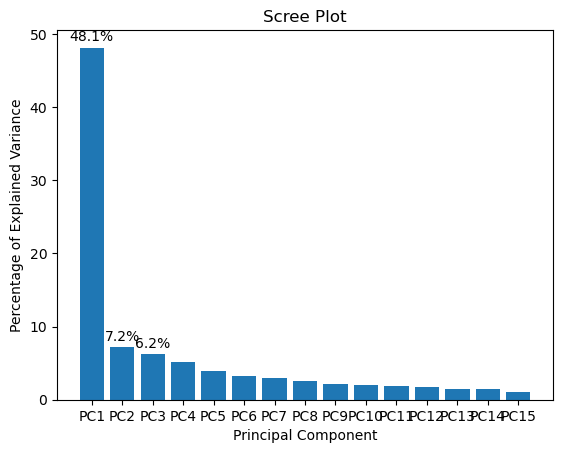

In [33]:
# PCA scree plot (amount of variation captured in each principaled component)
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range (1, len(per_var)+1)]
bars = plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
for bar, val in zip(bars[:3], per_var[:3]): # Just the first three should be enough
  plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f"{val}%", ha='center', va='bottom')
plt.show()

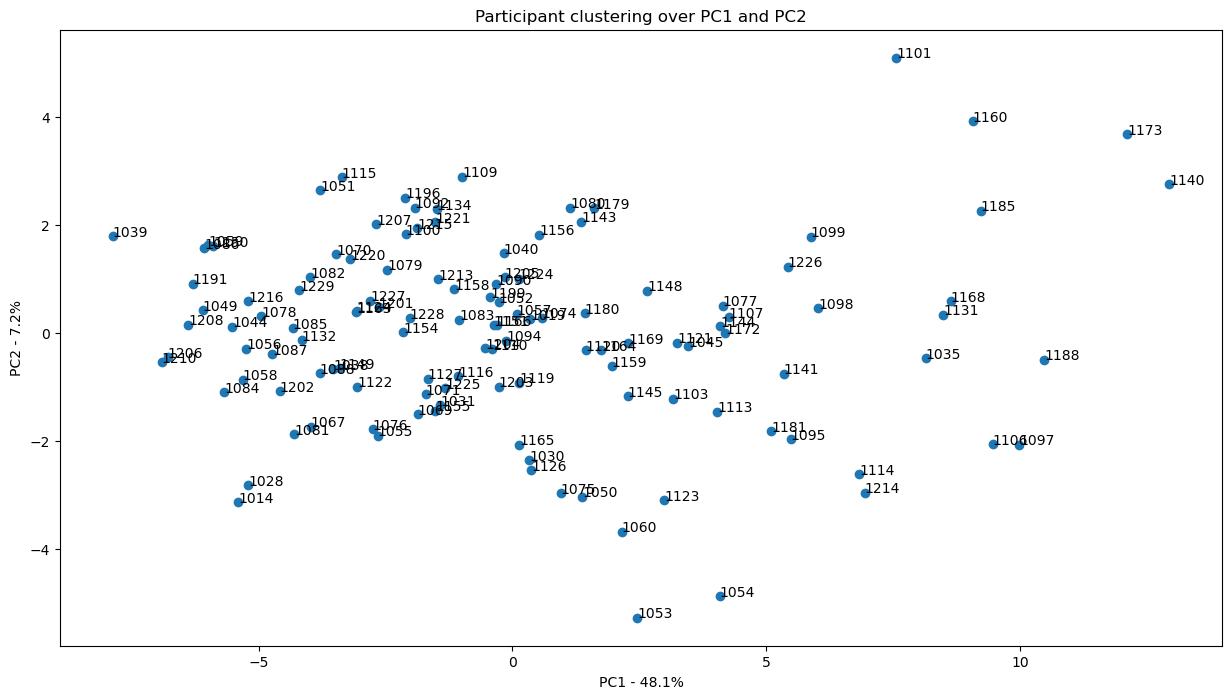

In [34]:
# Looking at how participants cluster along the first 2 principal components
pca_data = pca.transform(scaled_data) # Generate coordinates for graph
fig,ax = plt.subplots(figsize=(15,8))
pca_df = pd.DataFrame(pca_data, index=[index for index, __ in data.iterrows()], columns=labels)
ax.scatter(pca_df.PC1, pca_df.PC2)
ax.set_title("Participant clustering over PC1 and PC2")
ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
for sample in pca_df.index:
  ax.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
plt.show()


# PCA Loadings

Loading notes:
- The sign tells you whether the INCLUSION (+) or ABSENSE (-) of it contributes to the PC.
- The mangitude tells you how much the inclusion/absense of it contributes (higher = more contribution).

For now, we can look at which variables are informative or redundant. Here are some notes:
- Variables that contribute heavily to the same PC are likely redundant (PCA combines them into the same signal)
- Variables that contribute across many components are important and complex
- Variables with low contributions across many components are probably uninformative

Furthermore, loading plots will tell us information about variables
- Variables grouped together will be positively correlated (tendency to change the same way, but is it safe to call this redundant?)
- Variables opposite to each other w/ respect to the origin are negatively correlated 
- Variables farther to the origin are "stronger" / more influential.

In [35]:
# Let's focus on the PC's that explain 95% of the variation in the data
threshold = 0.95
loading_tables = []
total_variance = 0.0
pc_index = 0
loading_df = pd.DataFrame(pca.components_.T, columns=labels, index=columns)
while total_variance < threshold and pc_index < len(pca.explained_variance_ratio_):

	# Update variance tracker
	total_variance += pca.explained_variance_ratio_[pc_index]

	# Sort the respective PC based off of loadings
	sorted = loading_df.iloc[:, pc_index].copy()
	sorted = sorted.reindex(sorted.abs().sort_values(ascending=False).index)
	sorted = sorted.reset_index().rename(columns={'index': f'PCA{pc_index+1}_index'})

	# Save and move on to the next
	loading_tables.append(sorted)
	pc_index += 1

# Combine into 1 giant dataframe
all_loading_dfs = pd.concat(loading_tables, axis=1)
print(f"\nLoadings: {pc_index} PCs needed in order to explain {total_variance*100:.2f}% variation\n")
print(all_loading_dfs.to_string())


Loadings: 15 PCs needed in order to explain 91.05% variation

                   PCA1_index       PC1                 PCA2_index       PC2                 PCA3_index           PC3                 PCA4_index           PC4                 PCA5_index           PC5                 PCA6_index           PC6                 PCA7_index           PC7                 PCA8_index           PC8                 PCA9_index           PC9                PCA10_index          PC10                PCA11_index          PC11                PCA12_index          PC12                PCA13_index          PC13                PCA14_index          PC14                PCA15_index          PC15
0                       PTA_A  0.205734                      B_500  0.303938                    A_16000  3.339342e-01                    A_20000  3.460912e-01                    A_20000  3.629360e-01                      B_250  3.846900e-01                        EAR  4.911968e-01                   PEAKCOMP  4.955763e-01     

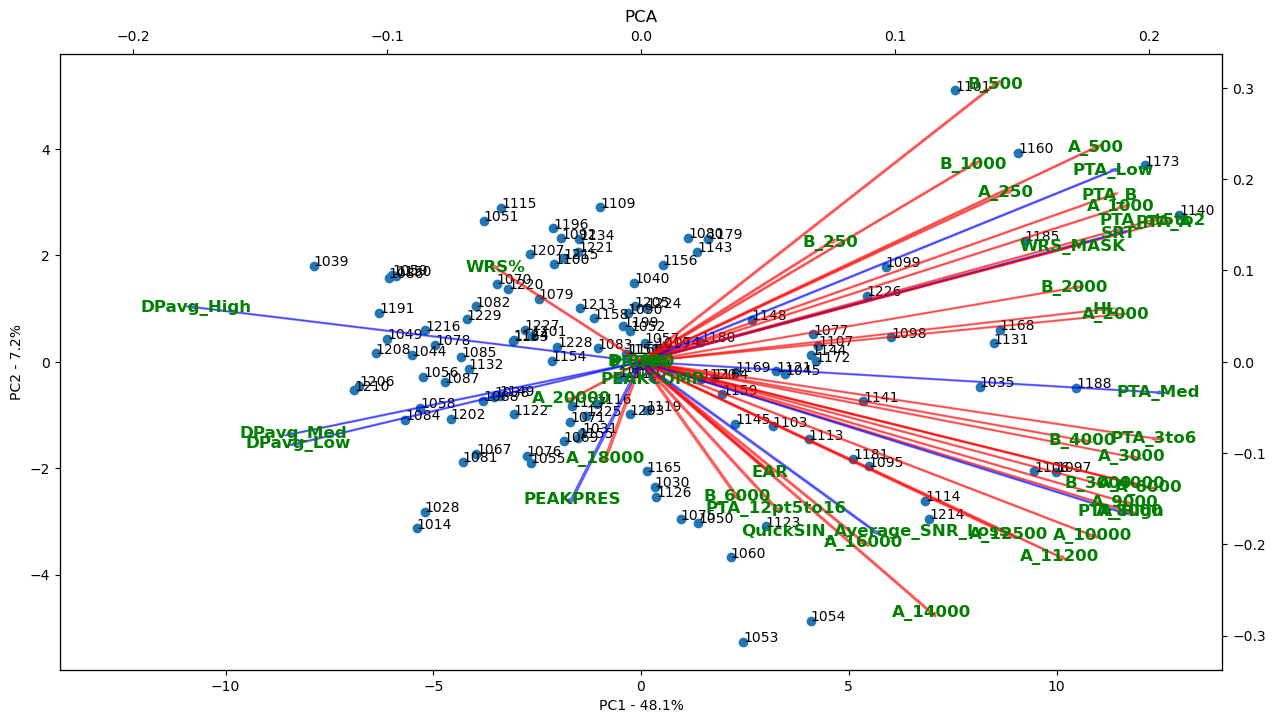

In [36]:
# Loadings Biplot (combining loadings information with what we saw before)
pca_title = "PCA"
highlight = brett_columns

# Generate Biplot
fig,ax = plt.subplots(figsize=(15,8))
pca_df = pd.DataFrame(pca_data, index=[index for index, __ in data.iterrows()], columns=labels)
ax.scatter(pca_df.PC1, pca_df.PC2)
ax.set_title(pca_title)
ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
for sample in pca_df.index:
  ax.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
ax2 = ax.twinx().twiny() # Plot loadings on this same graph. Credit: https://insidelearningmachines.com/biplot/
font = {'color':  'g',
  'weight': 'bold',
  'size': 12,
  }
for col in loading_df.T.columns.values:
  tipx = loading_df.T.loc['PC1',col]
  tipy = loading_df.T.loc['PC2',col]
  ax2.arrow(0, 0, tipx, tipy, color = 'blue' if col in highlight else 'r', alpha = 0.5)
  ax2.text(tipx, tipy, col, fontdict = font, ha = 'center', va = 'center')
mpl_axes_aligner.align.xaxes(ax, 0, ax2, 0, 0.5)
mpl_axes_aligner.align.yaxes(ax, 0, ax2, 0, 0.5)
plt.show()


# PCA Communalities (Factor Analysis)

Notes on factor analysis:
- A common way to look at PCA number is to consider them as factors.
- A statistician will fight to the death telling you not to treat PCA as a factor analysis, but it's generally accepted in machine learning.
- To have a factor analysis interpretation, we treat variables as clusters and see how much variation each variable share/contributes within a PC

Factor analysis terms:
- Communality is the amount of variation a variable contributes to the first "m" number of Principle Components

In [37]:
# Communalities
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)	# Loadings matrix (variables * components)
communalities = np.sum(loadings[:, :c_components]**2, axis=1) # Communality = sum of squared loadings for first m PCs
communalities_percent = (communalities * 100).round(2)
communalities_df = pd.DataFrame({
    'Variable': columns,
    'Communality': communalities_percent
}).set_index('Variable')
print("\nCommunalities Percentage (first", c_components, "components):")
print(communalities_df.reindex(communalities_df.abs().sort_values(by='Communality', ascending=False).index))



Communalities Percentage (first 3 components):
                           Communality
Variable                              
PTA_A                            93.44
PTA_pt5to2                       89.91
PTA_Med                          88.51
A_6000                           88.12
PTA_3to6                         88.03
PTA_Low                          86.37
A_4000                           85.81
A_500                            85.22
A_3000                           84.41
A_8000                           84.24
A_9000                           81.66
A_1000                           81.63
PTA_High                         81.29
PTA_B                            79.84
SRT                              78.95
B_3000                           76.06
A_10000                          75.59
A_2000                           74.51
A_11200                          69.72
HL                               68.98
B_500                            68.88
B_4000                           67.56
A_14000         

# K-Means Cluster Analysis

In [38]:
# 1) Figure out optimal clusters
def elbow_k_means(df: pd.DataFrame, max_k: int):

  """
  Params:
  - df: must have indices as examples
  - max_k: most amount of clusters you wanna try
  Interpretation note: Look at where it starts to flatten. That will be the optimal K.
  """

  means = []
  inertias = []
  for k in range (1, max_k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df)
    means.append(k)
    inertias.append(kmeans.inertia_)
  fig = plt.subplots(figsize=(8,6))
  plt.plot(means, inertias, 'o-')
  plt.xlabel('Clusters')
  plt.ylabel('Inertia')
  plt.grid(True)
  plt.show()

# 2) Run K-means on that # of clusters
def general_k_means(df: pd.DataFrame, k: int, random_state: int, prints=True):

  """
  Params:
  - df: must have indices as examples
  - k: number of clusters
  - prints: print statements
  """

  # Clean up
  df_result = df.copy()
  df_result.dropna(inplace=True)
  if prints:
    print(f"Length after dropping NA values, {len(df_result)}")

  # Standardize
  df_scaled = preprocessing.scale(df_result) # Centering makes the average 0. Scaling makes the standard deviation 1.

  # Create clusters
  kmeans = KMeans(n_clusters=k,
                  random_state=random_state,
                  n_init=10, # Increased n_init might lead to less variation in K-mean clusters due to randomness
                  max_iter=1000,
                  tol=0)
  kmeans.fit(df_scaled)

  # Return the df with labeled clusters
  df_result['kmeans'] = kmeans.labels_
  return df_result

# 3) Figure out why K-means is clustering it that way
def plot_k_means(df: pd.DataFrame, x: str, y: str):

  """
  Params:
  - df: MUST have kmeans column
  - kmeans: MUST be a valid column in df
  - x: MUST be a valid column in df (set x and y to "ALL" to plot all)
  - y: MUST be a valid column in df (set x and y to "ALL" to plot all)
  """

  # Plot all combinations of variables
  if x == "ALL" and y == "ALL":

    # Clean columns & shape into list of (column_names, column_datas) pairs
    data = []
    for combination in itertools.combinations(df.drop(columns=['kmeans']), 2):
      x_name, y_name = combination
      df_cleaned = df[[x_name, y_name, 'kmeans']].apply(pd.to_numeric, errors='coerce').dropna()
      if len(df_cleaned) == 0:
        print(f"{x_name} and {y_name} skipped, all NA's")
        continue
      data.append((x_name, y_name, df_cleaned))

    # Define subplots
    n = len(data)
    cols = 5
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 2.5))
    axes = axes.flatten()

    # Create subplots
    for i, (x_name, y_name, df_cleaned) in enumerate(data):
      sns.scatterplot(
          x=x_name,
          y=y_name,
          hue='kmeans',
          data=df_cleaned,
          ax=axes[i]
      )
      axes[i].set_title(f"X={x_name}, Y={y_name}")
      axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

  # Plot the two variables
  else:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=x, y=y, hue='kmeans', data=df)
    plt.title(f"X={x}, Y={y}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


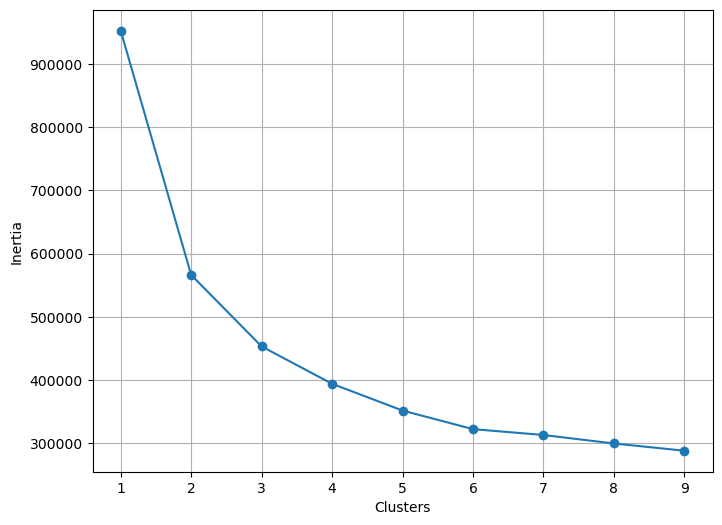

In [39]:
elbow_k_means(df=final_df[final_df.columns.difference(logistic_columns)], max_k=10)

# We need to pick where the slope begins to flatten.
# It seems like it starts to flatten around 3, but since 3 is too little, let's just pick 4.

Length after dropping NA values, 123


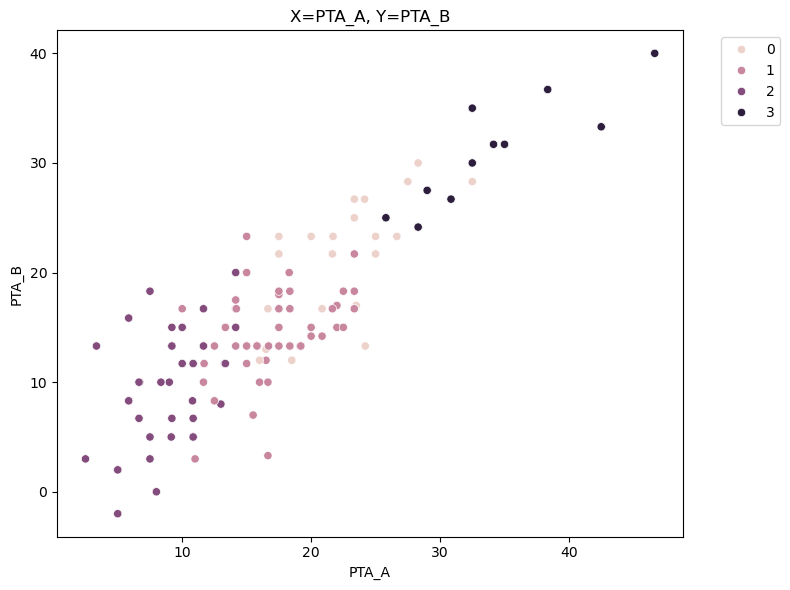

In [40]:
# Append a column called "kmeans"
k_means_df = general_k_means(df=final_df[final_df.columns.difference(logistic_columns)], k=4, random_state=50)

# Interpretting K-Means: a few columns
plot_k_means(df=k_means_df, x='PTA_A', y='PTA_B')

# Interpretting K-Means: all combinations of x & y axes
# plot_k_means(df=k_means_df, x='ALL', y='ALL')

# Extra Visualizations

In [41]:
# Before running both of them together, let's ensure they're the same length & have the same indices.
print(f"Same length: {len(k_means_df) == len(pca_df) == len(final_df)}")
print(f"Same indices: {((k_means_df.index == pca_df.index) == (final_df.index == pca_df.index)).all()}")

Same length: True
Same indices: True


In [42]:
# If the dataframes are the same length and all indices are the same, let's combine all the information we have.
combined_df = pd.concat([pca_df, k_means_df['kmeans'], final_df])
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 369 entries, 1014 to 1229
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PC1                        123 non-null    float64
 1   PC2                        123 non-null    float64
 2   PC3                        123 non-null    float64
 3   PC4                        123 non-null    float64
 4   PC5                        123 non-null    float64
 5   PC6                        123 non-null    float64
 6   PC7                        123 non-null    float64
 7   PC8                        123 non-null    float64
 8   PC9                        123 non-null    float64
 9   PC10                       123 non-null    float64
 10  PC11                       123 non-null    float64
 11  PC12                       123 non-null    float64
 12  PC13                       123 non-null    float64
 13  PC14                       123 non-null    float64


<Axes: xlabel='PC1', ylabel='PC2'>

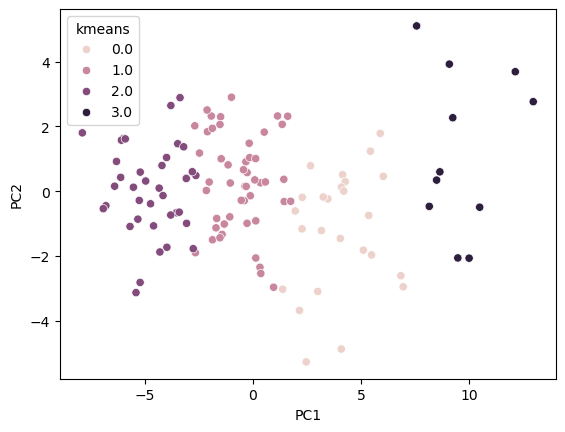

In [43]:
# Plot PC1 and PC2, with the hue being the kmeans cluster
# Prediction: kmeans will follow a gradient along the x-axis (PC1)
sns.scatterplot(x="PC1",y="PC2",hue="kmeans",data=combined_df)

<Axes: xlabel='PC1', ylabel='PC2'>

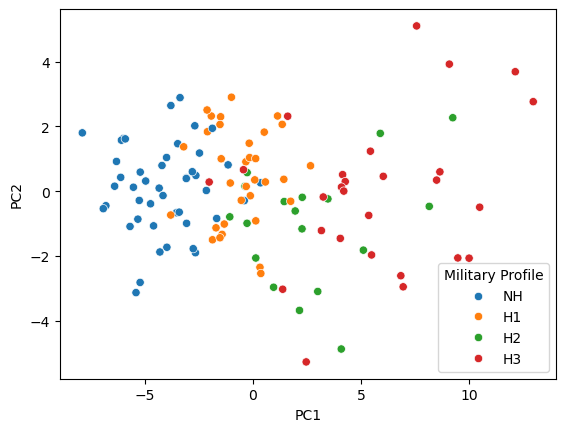

In [44]:
# Plot PC1 and PC2, with the hue being the profile cluster
# Prediction: Military profile will follow a gradient along the x-axis (PC1)
sns.scatterplot(x="PC1",y="PC2",hue="Military Profile",data=combined_df)